In [14]:
# Install the missing library again (it got wiped during the restart)
!pip install segmentation-models-pytorch

# Quick check to ensure decoders are there too
!pip install -q pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg

In [10]:
!pip install tqdm

In [19]:
import os
import cv2
import pydicom
import random
import warnings
import numpy as np
import pandas as pd
import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

# Suppress Warnings
warnings.filterwarnings("ignore")

# CONFIGURATION
CONFIG = {
    "BASE_PATH": "/kaggle/input/rsna-2023-abdominal-trauma-detection",
    "IMG_SIZE": 256,
    "BATCH_SIZE": 64,  # Optimized for 2x T4 GPUs
    "LR": 0.0005,
    "EPOCHS": 3,
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu",
    "NUM_WORKERS": 0   # CRITICAL: Keep at 0 to prevent Kaggle Deadlocks
}
print(f"⚙️ Config Loaded. Using device: {CONFIG['DEVICE']}")

⚙️ Config Loaded. Using device: cuda


In [20]:
print("⏳ Scanning Dataset for valid slices (approx 2 mins)...")

# 1. Load Metadata & Fix IDs
meta_df = pd.read_csv(os.path.join(CONFIG['BASE_PATH'], "train_series_meta.csv"))
meta_df['patient_id'] = meta_df['patient_id'].astype(int).astype(str)
meta_df['series_id'] = meta_df['series_id'].astype(int).astype(str)

SEG_PATH = os.path.join(CONFIG['BASE_PATH'], "segmentations")
TRAIN_IMAGES_PATH = os.path.join(CONFIG['BASE_PATH'], "train_images")

# 2. Filter for available masks
available_masks = [f.split('.')[0] for f in os.listdir(SEG_PATH) if f.endswith('.nii')]
df_seg = meta_df[meta_df['series_id'].isin(available_masks)].reset_index(drop=True)

# 3. Explode Dataset (Find all valid slices)
slice_data = []
for idx, row in tqdm(df_seg.iterrows(), total=len(df_seg), desc="Indexing"):
    mask_path = os.path.join(SEG_PATH, f"{row['series_id']}.nii")
    try:
        # Fast load to check for organs
        mask_nii = nib.load(mask_path)
        slice_sums = mask_nii.get_fdata().sum(axis=(0,1))
        valid_indices = np.where(slice_sums > 0)[0]
        
        for z in valid_indices:
            slice_data.append({
                'patient_id': row['patient_id'],
                'series_id': row['series_id'],
                'z_index': z,
                'mask_path': mask_path,
                'image_folder': os.path.join(TRAIN_IMAGES_PATH, row['patient_id'], row['series_id'])
            })
    except Exception:
        continue

full_slice_df = pd.DataFrame(slice_data)
print(f"✅ FOUND {len(full_slice_df)} VALID SLICES!")

# 4. Patient-Aware Split
unique_patients = full_slice_df['patient_id'].unique()
train_ids, valid_ids = train_test_split(unique_patients, test_size=0.1, random_state=42)

train_df = full_slice_df[full_slice_df['patient_id'].isin(train_ids)].reset_index(drop=True)
valid_df = full_slice_df[full_slice_df['patient_id'].isin(valid_ids)].reset_index(drop=True)

print(f"📊 Train: {len(train_df)} | Valid: {len(valid_df)}")

⏳ Scanning Dataset for valid slices (approx 2 mins)...


Indexing:   0%|          | 0/206 [00:00<?, ?it/s]

✅ FOUND 62014 VALID SLICES!
📊 Train: 57489 | Valid: 4525


In [23]:
# 1. STOP THE OPEN_CV DEADLOCK (Critical Fix)
cv2.setNumThreads(0)

# 2. Update Configuration for Speed
CONFIG['NUM_WORKERS'] = 2  # Re-enable workers safely
CONFIG['BATCH_SIZE'] = 64  # Keep this for 2 GPUs

print(f"⚙️ Config Updated: Workers={CONFIG['NUM_WORKERS']}, Batch={CONFIG['BATCH_SIZE']}")

# 3. Add Debugging to Dataset Class
class RSNASliceDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.file_cache = {} 
        
    def load_dicom(self, folder_path, filename):
        try:
            path = os.path.join(folder_path, filename)
            if not os.path.exists(path): return np.zeros((512, 512), dtype=np.float32) - 1000
            dicom = pydicom.dcmread(path)
            img = dicom.pixel_array.astype(np.float32)
            slope = getattr(dicom, 'RescaleSlope', 1)
            intercept = getattr(dicom, 'RescaleIntercept', 0)
            return img * slope + intercept
        except:
            return np.zeros((512, 512), dtype=np.float32) - 1000

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # DEBUG: Print only for the very first item to prove it's alive
        if idx == 0:
            print(f"🔎 Loading sample {idx} (System is active!)...")

        row = self.dataframe.iloc[idx]
        z_idx = int(row['z_index'])
        dicom_folder = row['image_folder']
        
        try:
            if dicom_folder in self.file_cache:
                sorted_files = self.file_cache[dicom_folder]
            else:
                all_files = os.listdir(dicom_folder)
                sorted_files = sorted([f for f in all_files if f.endswith('.dcm')], 
                                      key=lambda x: int(x.split('.')[0]))
                self.file_cache[dicom_folder] = sorted_files
            
            def get_file(i): return sorted_files[max(0, min(i, len(sorted_files)-1))]
            
            img_stack = np.stack([
                self.load_dicom(dicom_folder, get_file(z_idx - 1)),
                self.load_dicom(dicom_folder, get_file(z_idx)),
                self.load_dicom(dicom_folder, get_file(z_idx + 1))
            ], axis=-1)

            mask_nii = nib.load(row['mask_path'])
            mask_vol = np.fliplr(np.rot90(mask_nii.get_fdata(), k=1))
            mask_slice = mask_vol[:, :, z_idx]

            img_stack = np.clip(img_stack, -150, 250)
            img_stack = (img_stack - np.min(img_stack)) / (np.max(img_stack) - np.min(img_stack) + 1e-8)

            img_stack = cv2.resize(img_stack, (CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']))
            mask_slice = cv2.resize(mask_slice, (CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']), interpolation=cv2.INTER_NEAREST)

            if self.transform:
                aug = self.transform(image=img_stack, mask=mask_slice)
                img_stack, mask_slice = aug['image'], aug['mask']
            
            return img_stack, mask_slice.long()
            
        except Exception:
            return torch.zeros((3, CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE'])), torch.zeros((CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE'])).long()

# 4. Re-initialize Loaders with new worker settings
train_ds = RSNASliceDataset(train_df, transform=train_transforms)
valid_ds = RSNASliceDataset(valid_df, transform=valid_transforms)

train_loader = DataLoader(train_ds, batch_size=CONFIG['BATCH_SIZE'], shuffle=True, num_workers=CONFIG['NUM_WORKERS'])
valid_loader = DataLoader(valid_ds, batch_size=CONFIG['BATCH_SIZE'], shuffle=False, num_workers=CONFIG['NUM_WORKERS'])

print("✅ System optimized. Run the Training Loop cell again now!")

⚙️ Config Updated: Workers=2, Batch=64
✅ System optimized. Run the Training Loop cell again now!


In [24]:
import torch.nn as nn
import torch.optim as optim
import segmentation_models_pytorch as smp
from tqdm.notebook import tqdm

# ==========================================
# 1. MODEL SETUP (MobileNetV3)
# ==========================================
print("🏗️ Building MobileNetV3-UNet Model...")

# Define Model
model = smp.Unet(
    encoder_name="timm-mobilenetv3_large_100", 
    encoder_weights="imagenet", 
    in_channels=3, 
    classes=6,
    decoder_use_batchnorm=True
)

# Enable 2x GPU Support (DataParallel)
if torch.cuda.device_count() > 1:
    print(f"🚀 Detected {torch.cuda.device_count()} GPUs! Enabling DataParallel.")
    model = nn.DataParallel(model)

model.to(CONFIG['DEVICE'])

# Loss & Optimizer
optimizer = optim.AdamW(model.parameters(), lr=CONFIG['LR'])
loss_fn = smp.losses.DiceLoss(mode='multiclass', from_logits=True)

# ==========================================
# 2. TRAINING LOOP
# ==========================================
print(f"🔥 Starting Training on {CONFIG['DEVICE']}...")

best_valid_loss = float("inf")

for epoch in range(CONFIG['EPOCHS']):
    model.train()
    train_loss = 0
    
    # Train Loop
    # Note: The first time this runs, it might take 10-20s to start while filling the buffer
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG['EPOCHS']} [Train]")
    
    for images, masks in pbar:
        images = images.to(CONFIG['DEVICE']).float()
        masks = masks.to(CONFIG['DEVICE']).long()
        
        optimizer.zero_grad()
        
        # Forward Pass
        outputs = model(images)
        
        # Loss Calculation
        loss = loss_fn(outputs, masks)
        
        # Backward Pass
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        # Update Progress Bar
        pbar.set_postfix({"Loss": f"{loss.item():.4f}"})
        
    # Validation Loop
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        vbar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{CONFIG['EPOCHS']} [Valid]")
        for images, masks in vbar:
            images = images.to(CONFIG['DEVICE']).float()
            masks = masks.to(CONFIG['DEVICE']).long()
            
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            valid_loss += loss.item()
            
    # Calculate Averages
    avg_train_loss = train_loss / len(train_loader)
    avg_valid_loss = valid_loss / len(valid_loader)
    
    print(f"✅ Epoch {epoch+1} Results: Train Loss: {avg_train_loss:.4f} | Valid Loss: {avg_valid_loss:.4f}")
    
    # Save Best Model
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        # Handle DataParallel saving (unwrap the model)
        state_dict = model.module.state_dict() if hasattr(model, 'module') else model.state_dict()
        torch.save(state_dict, "best_mobilenet_rsna.pth")
        print(f"💾 Best Model Saved (Loss: {best_valid_loss:.4f})")

print("🎉 Training Complete!")

🏗️ Building MobileNetV3-UNet Model...
🚀 Detected 2 GPUs! Enabling DataParallel.
🔥 Starting Training on cuda...


Epoch 1/3 [Train]:   0%|          | 0/899 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

# Load Best Model
model.eval()

# Pick random sample
idx = random.randint(0, len(valid_ds)-1)
img, mask = valid_ds[idx]

with torch.no_grad():
    input_t = img.unsqueeze(0).to(CONFIG['DEVICE'])
    pred = model(input_t)
    pred_mask = torch.argmax(pred, dim=1).squeeze(0).cpu()

# Plot
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img[1,:,:], cmap='gray')
ax[0].set_title("CT Input")
ax[1].imshow(mask, cmap='nipy_spectral', vmin=0, vmax=5)
ax[1].set_title("Ground Truth")
ax[2].imshow(pred_mask, cmap='nipy_spectral', vmin=0, vmax=5)
ax[2].set_title("Prediction")
plt.show()

⏳ Scanning masks (Parallel Mode)...
   Processing masks...
✅ Found 62014 valid slices.
✂️ Reducing dataset to random 2000 slices...
📊 Final Split: 1800 Train | 200 Valid
🏗️ Building MobileNetV3...
🚀 Using 2 GPUs!
🔥 Starting Training...

--- Epoch 1/5 ---
   Batch 5/29 | Loss: 0.9206
   Batch 10/29 | Loss: 0.9029
   Batch 15/29 | Loss: 0.8839
   Batch 20/29 | Loss: 0.8735
   Batch 25/29 | Loss: 0.8643
✅ Epoch 1 Finished in 3755s. Train: 0.8901 | Valid: 0.8574
   💾 Best Model Saved!

--- Epoch 2/5 ---
   Batch 5/29 | Loss: 0.8310
   Batch 10/29 | Loss: 0.8309
   Batch 15/29 | Loss: 0.8049
   Batch 20/29 | Loss: 0.8088
   Batch 25/29 | Loss: 0.7669
✅ Epoch 2 Finished in 3665s. Train: 0.8072 | Valid: 0.7679
   💾 Best Model Saved!

--- Epoch 3/5 ---
   Batch 5/29 | Loss: 0.7390
   Batch 10/29 | Loss: 0.7509
   Batch 15/29 | Loss: 0.7294
   Batch 20/29 | Loss: 0.7188
   Batch 25/29 | Loss: 0.7074
✅ Epoch 3 Finished in 3560s. Train: 0.7262 | Valid: 0.7407
   💾 Best Model Saved!

--- Epoch 4/5

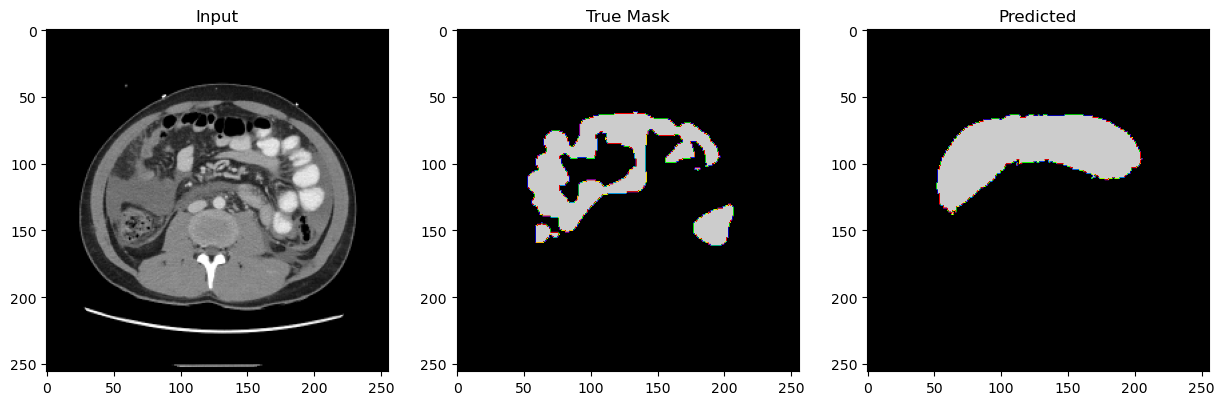

In [15]:
import os
import time
import cv2
import pydicom
import random
import warnings
import numpy as np
import pandas as pd
import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed

# --- CRITICAL FIXES ---
cv2.setNumThreads(0)            # Prevent OpenCV deadlock
warnings.filterwarnings("ignore") # Clean up output logs

# ==========================================
# 1. CONFIGURATION
# ==========================================
CONFIG = {
    "BASE_PATH": "/kaggle/input/rsna-2023-abdominal-trauma-detection",
    "IMG_SIZE": 256,
    "BATCH_SIZE": 64,    # Optimized for 2x T4 GPUs
    "LR": 0.0005,
    "EPOCHS": 5,
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu",
    "NUM_WORKERS": 2,    # Safe to use 2 workers now
    "TARGET_SIZE": 2000  # Limit dataset for fast testing
}

# ==========================================
# 2. DATA PREPARATION
# ==========================================
print("⏳ Scanning masks (Parallel Mode)...")

meta_df = pd.read_csv(os.path.join(CONFIG['BASE_PATH'], "train_series_meta.csv"))
meta_df['patient_id'] = meta_df['patient_id'].astype(int).astype(str)
meta_df['series_id'] = meta_df['series_id'].astype(int).astype(str)

SEG_PATH = os.path.join(CONFIG['BASE_PATH'], "segmentations")
TRAIN_IMAGES_PATH = os.path.join(CONFIG['BASE_PATH'], "train_images")

available_masks = [f.split('.')[0] for f in os.listdir(SEG_PATH) if f.endswith('.nii')]
df_seg = meta_df[meta_df['series_id'].isin(available_masks)].reset_index(drop=True)

# Helper for Parallel Processing
def process_mask(row):
    results = []
    mask_path = os.path.join(SEG_PATH, f"{row['series_id']}.nii")
    try:
        mask_nii = nib.load(mask_path)
        mask_data = mask_nii.get_fdata()
        # Find slices that actually have organs (Sum > 0)
        valid_indices = np.where(mask_data.sum(axis=(0,1)) > 0)[0]
        
        for z in valid_indices:
            results.append({
                'patient_id': row['patient_id'],
                'series_id': row['series_id'],
                'z_index': z,
                'mask_path': mask_path,
                'image_folder': os.path.join(TRAIN_IMAGES_PATH, row['patient_id'], row['series_id'])
            })
    except:
        pass
    return results

# Run Parallel Scan (4 Cores)
# Note: tqdm removed here too to prevent errors
print("   Processing masks...") 
slice_lists = Parallel(n_jobs=4, prefer="threads")(
    delayed(process_mask)(row) for _, row in df_seg.iterrows()
)
slice_data = [item for sublist in slice_lists for item in sublist]

full_slice_df = pd.DataFrame(slice_data)
print(f"✅ Found {len(full_slice_df)} valid slices.")

# --- REDUCE TO 2000 ---
if len(full_slice_df) > CONFIG['TARGET_SIZE']:
    print(f"✂️ Reducing dataset to random {CONFIG['TARGET_SIZE']} slices...")
    full_slice_df = full_slice_df.sample(n=CONFIG['TARGET_SIZE'], random_state=42).reset_index(drop=True)

# Split
train_df, valid_df = train_test_split(full_slice_df, test_size=0.1, random_state=42)
print(f"📊 Final Split: {len(train_df)} Train | {len(valid_df)} Valid")

# ==========================================
# 3. OPTIMIZED DATASET CLASS
# ==========================================
class RSNASliceDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.file_cache = {} # Cache file lists to prevent lag
        
    def load_dicom(self, folder_path, filename):
        try:
            path = os.path.join(folder_path, filename)
            if not os.path.exists(path): return np.zeros((512, 512), dtype=np.float32) - 1000
            dicom = pydicom.dcmread(path)
            img = dicom.pixel_array.astype(np.float32)
            slope = getattr(dicom, 'RescaleSlope', 1)
            intercept = getattr(dicom, 'RescaleIntercept', 0)
            return img * slope + intercept
        except:
            return np.zeros((512, 512), dtype=np.float32) - 1000

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        z_idx = int(row['z_index'])
        dicom_folder = row['image_folder']
        
        try:
            # OPTIMIZATION: Check Cache
            if dicom_folder in self.file_cache:
                sorted_files = self.file_cache[dicom_folder]
            else:
                all_files = os.listdir(dicom_folder)
                sorted_files = sorted([f for f in all_files if f.endswith('.dcm')], 
                                      key=lambda x: int(x.split('.')[0]))
                self.file_cache[dicom_folder] = sorted_files
            
            def get_file(i): return sorted_files[max(0, min(i, len(sorted_files)-1))]
            
            # Load 2.5D Stack
            img_stack = np.stack([
                self.load_dicom(dicom_folder, get_file(z_idx - 1)),
                self.load_dicom(dicom_folder, get_file(z_idx)),
                self.load_dicom(dicom_folder, get_file(z_idx + 1))
            ], axis=-1)

            mask_nii = nib.load(row['mask_path'])
            mask_vol = np.fliplr(np.rot90(mask_nii.get_fdata(), k=1))
            mask_slice = mask_vol[:, :, z_idx]

            # Preprocess
            img_stack = np.clip(img_stack, -150, 250)
            img_stack = (img_stack - np.min(img_stack)) / (np.max(img_stack) - np.min(img_stack) + 1e-8)

            img_stack = cv2.resize(img_stack, (CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']))
            mask_slice = cv2.resize(mask_slice, (CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']), interpolation=cv2.INTER_NEAREST)

            if self.transform:
                aug = self.transform(image=img_stack, mask=mask_slice)
                img_stack, mask_slice = aug['image'], aug['mask']
            
            return img_stack, mask_slice.long()
        except:
            return torch.zeros((3, CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE'])), torch.zeros((CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE'])).long()

# ==========================================
# 4. MODEL & LOADERS
# ==========================================
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=20, p=0.5),
    A.CoarseDropout(max_holes=8, max_height=20, max_width=20, p=0.2),
    ToTensorV2()
])
valid_transforms = A.Compose([ToTensorV2()])

train_ds = RSNASliceDataset(train_df, transform=train_transforms)
valid_ds = RSNASliceDataset(valid_df, transform=valid_transforms)

train_loader = DataLoader(train_ds, batch_size=CONFIG['BATCH_SIZE'], shuffle=True, num_workers=CONFIG['NUM_WORKERS'])
valid_loader = DataLoader(valid_ds, batch_size=CONFIG['BATCH_SIZE'], shuffle=False, num_workers=CONFIG['NUM_WORKERS'])

print("🏗️ Building MobileNetV3...")
model = smp.Unet(
    encoder_name="timm-mobilenetv3_large_100", 
    encoder_weights="imagenet", 
    in_channels=3, 
    classes=6,
    decoder_use_batchnorm=True
)

if torch.cuda.device_count() > 1:
    print(f"🚀 Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

model.to(CONFIG['DEVICE'])
optimizer = optim.AdamW(model.parameters(), lr=CONFIG['LR'])
loss_fn = smp.losses.DiceLoss(mode='multiclass', from_logits=True)

# ==========================================
# 5. TEXT-ONLY TRAINING LOOP (NO TQDM)
# ==========================================
print(f"🔥 Starting Training...")
best_loss = float("inf")

for epoch in range(CONFIG['EPOCHS']):
    model.train()
    train_loss = 0
    start_time = time.time()
    
    print(f"\n--- Epoch {epoch+1}/{CONFIG['EPOCHS']} ---")
    
    for batch_idx, (images, masks) in enumerate(train_loader):
        images = images.to(CONFIG['DEVICE']).float()
        masks = masks.to(CONFIG['DEVICE']).long()
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        # Simple print instead of progress bar
        if (batch_idx + 1) % 5 == 0:
            print(f"   Batch {batch_idx+1}/{len(train_loader)} | Loss: {loss.item():.4f}")

    # Validation
    model.eval()
    valid_loss = 0
    print("   Running Validation...", end="")
    with torch.no_grad():
        for images, masks in valid_loader:
            images = images.to(CONFIG['DEVICE']).float()
            masks = masks.to(CONFIG['DEVICE']).long()
            outputs = model(images)
            valid_loss += loss_fn(outputs, masks).item()
            
    avg_train = train_loss / len(train_loader)
    avg_valid = valid_loss / len(valid_loader)
    epoch_time = time.time() - start_time
    
    print(f"\r✅ Epoch {epoch+1} Finished in {epoch_time:.0f}s. Train: {avg_train:.4f} | Valid: {avg_valid:.4f}")
    
    if avg_valid < best_loss:
        best_loss = avg_valid
        if hasattr(model, 'module'):
            torch.save(model.module.state_dict(), "best_mobilenet.pth")
        else:
            torch.save(model.state_dict(), "best_mobilenet.pth")
        print("   💾 Best Model Saved!")

print("🎉 DONE!")

# ==========================================
# 6. VISUALIZE RESULTS
# ==========================================
import matplotlib.pyplot as plt
model.eval()
idx = random.randint(0, len(valid_ds)-1)
img, mask = valid_ds[idx]

with torch.no_grad():
    input_t = img.unsqueeze(0).to(CONFIG['DEVICE'])
    pred = model(input_t)
    pred_mask = torch.argmax(pred, dim=1).squeeze(0).cpu()

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img[1,:,:], cmap='gray'); ax[0].set_title("Input")
ax[1].imshow(mask, cmap='nipy_spectral', vmin=0, vmax=5); ax[1].set_title("True Mask")
ax[2].imshow(pred_mask, cmap='nipy_spectral', vmin=0, vmax=5); ax[2].set_title("Predicted")
plt.show()